In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd 
import math

In [2]:
## build a class to stocke the constante 
constante = lambda: None # Lazy way to define an empty class in python
constante.rho_l = 1260
constante.rho_b = 7870
constante.r = 6.7e-3
constante.H = 1.0
constante.dt = 1e-3
constante.g = 9.8

def dynball(x,t, p, const=constante):
    g = const.g
    rho_l = const.rho_l
    rho_b = const.rho_b
    r = const.r

    k = p[0]  # Viscous drag coefficient
    n = p[1]  # Power of velocity in the drag equation

    h = x[0]  # Ball's height
    v = x[1]  # Ball's velocity

    V = (4/3) * np.pi * r**3
    m = V * rho_b

    dhdt = v
    dvdt = -g + (rho_l * g / rho_b) + (k / m) * abs(v)**n

    dxdt = np.array([dhdt, dvdt])
    return dxdt


### Load the data

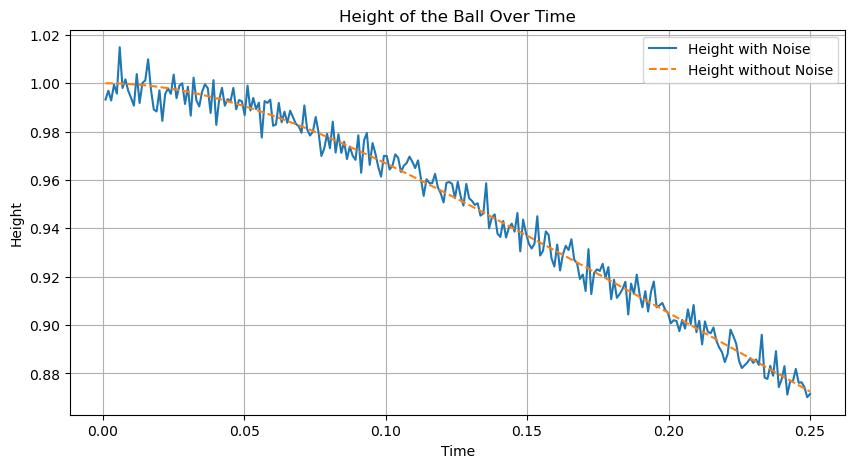

In [3]:
# Load the CSV file into a DataFrame
data_path_0 = 'data.csv'
data_path_1 = 'data_non_bruit.csv'
data = pd.read_csv(data_path_0)
data_non_noise = pd.read_csv(data_path_1)

# Assuming the first column is time and the second is height (h)
time = data.iloc[:, 0]
data_noise= data.iloc[:, 1]
data_non_noise =data_non_noise.iloc[:,1]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(time, data_noise, label='Height with Noise')
plt.plot(time, data_non_noise, label='Height without Noise', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height of the Ball Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def Model(p, t):
    x0 = [constante.H, .0]  # Initial condition: starting at the first height value with zero velocity
    sol = odeint(dynball, x0, t, args=(p, constante))
    y_hat = sol[:, 0]  # Extract the height predictions from the solution
    return y_hat

0.00605495969896096
0.07781362155150574


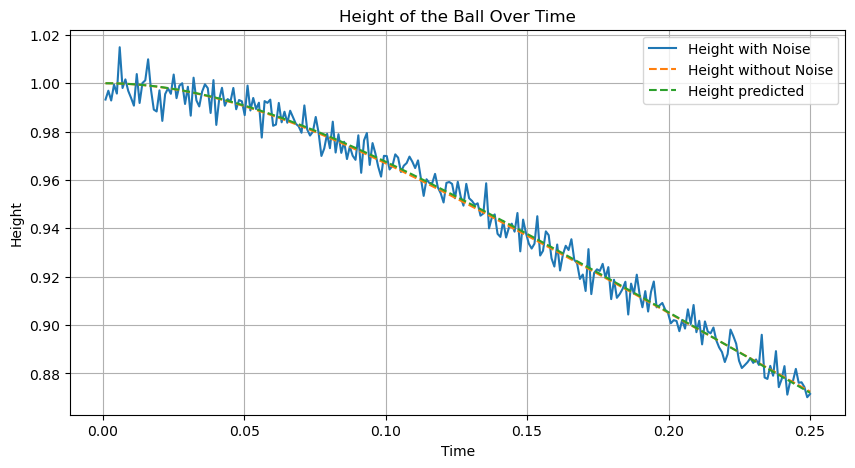

In [5]:
def critgrad(p, y, t):
    x0 = [constante.H, .0]  # Initial condition: starting at the first height value with zero velocity
    sol = odeint(dynball, x0, t, args=(p, constante))
    y_hat = sol[:, 0]  # Extract the height predictions from the solution

        # Calculate the cost function as the sum of squared differences
    c = np.sum((y - y_hat)**2)
    
    # Calculate the gradient of the cost function using finite difference
    delta = 1e-5  # A small perturbation for finite difference
    grad = np.zeros_like(p)
    for i in range(len(p)):
        p_delta = np.copy(p)
        p_delta[i] += delta
        sol_delta = odeint(dynball, x0, t, args=(p_delta, constante))
        y_hat_delta = sol_delta[:, 0]
        c_delta = np.sum((y - y_hat_delta)**2)
        grad[i] = (c_delta - c) / delta
    
    return c, grad

p_hat = np.array([0.16364295,1.77462433])
y = data_noise
y_hat = Model(p_hat,time)
c,grad = critgrad(p_hat,y,time)

print(c)
print(np.sqrt( np.sum((y_hat-y)**2)))
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(time, data_noise, label='Height with Noise')
plt.plot(time, data_non_noise, label='Height without Noise', linestyle='--')
plt.plot(time, y_hat, label='Height predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height of the Ball Over Time')
plt.legend()
plt.grid(True)
plt.show()

Iteration 1: Cost = 0.7541759392608453, Parameters = [0.99718588 1.00716289]
Iteration 2: Cost = 0.7482502214357372, Parameters = [0.99434264 1.01432264]
Iteration 3: Cost = 0.7423130440111687, Parameters = [0.99147061 1.02147774]
Iteration 4: Cost = 0.7363666085488074, Parameters = [0.98857011 1.02862681]
Iteration 5: Cost = 0.7304130200791377, Parameters = [0.9856415  1.03576823]
Iteration 6: Cost = 0.7244543984451026, Parameters = [0.9826851  1.04290071]
Iteration 7: Cost = 0.7184927968941934, Parameters = [0.97970126 1.05002263]
Iteration 8: Cost = 0.712530316491683, Parameters = [0.97669033 1.05713278]
Iteration 9: Cost = 0.7065688200818567, Parameters = [0.97365264 1.06422985]
Iteration 10: Cost = 0.7006101711298279, Parameters = [0.97058855 1.07131255]
Iteration 11: Cost = 0.694656261746294, Parameters = [0.96749839 1.07837971]
Iteration 12: Cost = 0.6887087442616475, Parameters = [0.96438253 1.08543008]
Iteration 13: Cost = 0.6827693790221324, Parameters = [0.96124129 1.0924625

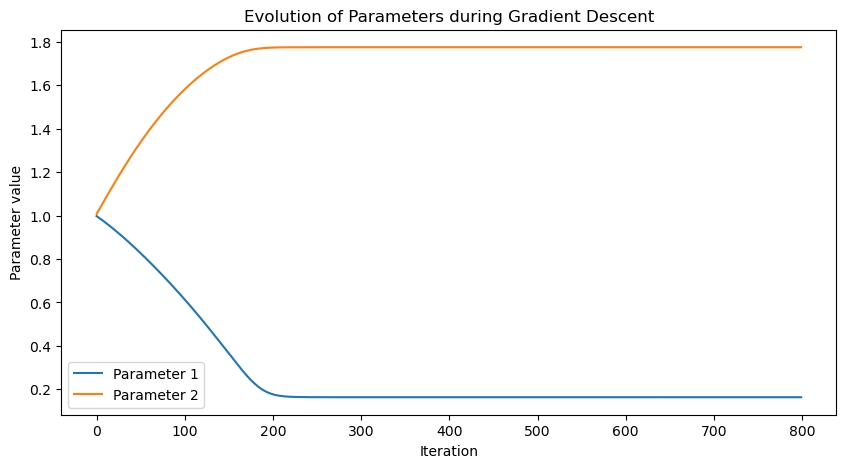

In [6]:
def gradient_descent(p_init, y, t, const, alpha, num_iterations):
    p = p_init.copy()
    p_history = []  # List to store the history of p values
    for i in range(num_iterations):
        c, grad = critgrad(p, y, t)
        p -= alpha * grad  # Update the parameter vector
        p_history.append(p.copy())  # Store the current value of p
        print(f"Iteration {i+1}: Cost = {c}, Parameters = {p}")
    return np.array(p_history)  # Return the history of p values as an array


# Run gradient descent and get the history of p values
p_init = np.array([1.0, 1.0])  # Initial parameter guess
alpha = 0.01  # Learning rate
num_iterations = 800  # Number of iterations
height = data_noise

# Perform the gradient descent to estimate the parameters
p_history = gradient_descent(p_init, height, time, constante, alpha, num_iterations)

# Plotting the evolution of the parameters
plt.figure(figsize=(10, 5))
for i in range(p_history.shape[1]):
    plt.plot(p_history[:, i], label=f'Parameter {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Evolution of Parameters during Gradient Descent')
plt.legend()
plt.show()


In [7]:
# Evaluate gradient of least-squares criterion (finite differences)
def eval_proj_mat(p):
    eps = 1e-8 # step size
    t= time
    ym =Model(p,t)
    
    J = np.zeros((len(ym),len(p))) 
    
    for i in range(len(p)):
        p_prime = p.copy() # very important to put .copy()
        p_prime[i] = p_prime[i] + eps

        ym_prime =Model(p_prime, t)
            
        J[:,i] = -(ym_prime-ym)/eps
    
    try:
        Pi_matrix = J@np.linalg.inv(J.transpose()@J)@J.transpose()
    except:
        Pi_matrix = np.empty((len(y),len(y)))
        Pi_matrix[:] = np.nan 
    
    return Pi_matrix

p_test = np.array([1.0, 1.75130319])
y_test = data_noise
Pi_matrix = eval_proj_mat(p_test)

[array([0.13, 1.42]), array([0.13, 1.43]), array([0.13, 1.44]), array([0.14, 1.51]), array([0.14, 1.52]), array([0.14, 1.53]), array([0.14, 1.54]), array([0.14, 1.55]), array([0.14, 1.56]), array([0.14, 1.57]), array([0.15, 1.6 ]), array([0.15, 1.61]), array([0.15, 1.62]), array([0.15, 1.63]), array([0.15, 1.64]), array([0.15, 1.65]), array([0.15, 1.66]), array([0.15, 1.67]), array([0.15, 1.68]), array([0.15, 1.69]), array([0.16, 1.7 ]), array([0.16, 1.71]), array([0.16, 1.72]), array([0.16, 1.73]), array([0.16, 1.74]), array([0.16, 1.75]), array([0.16, 1.76]), array([0.16, 1.77]), array([0.16, 1.78]), array([0.16, 1.79]), array([0.17, 1.79]), array([0.17, 1.8 ]), array([0.17, 1.81]), array([0.17, 1.82]), array([0.17, 1.83]), array([0.17, 1.84]), array([0.17, 1.85]), array([0.17, 1.86]), array([0.17, 1.87]), array([0.17, 1.88]), array([0.18, 1.87]), array([0.18, 1.88]), array([0.18, 1.89]), array([0.18, 1.9 ]), array([0.18, 1.91]), array([0.18, 1.92]), array([0.18, 1.93]), array([0.18,

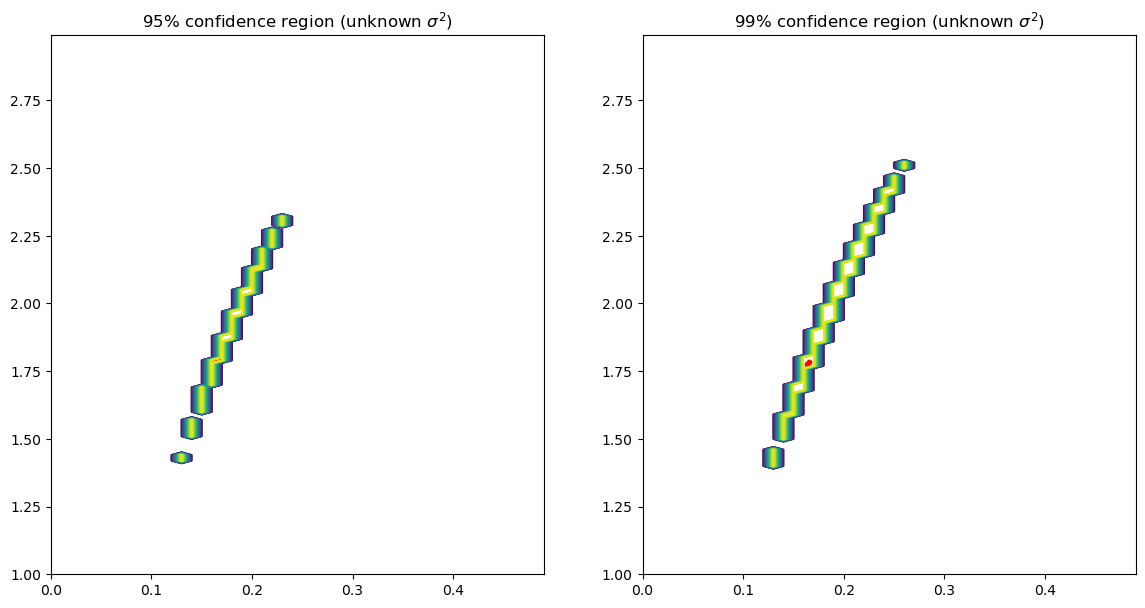

In [8]:
from scipy.stats import f
y = data_noise

p1 = np.arange(0,0.5, 0.01)
p2 = np.arange(1, 3, 0.01)

p1_est,p2_est = np.meshgrid(p1,p2, indexing='ij')


# Thresholds for Fisher-Snedecor distribution 
thresh_05 = f.ppf(0.95,2,len(y)-2)
thresh_01 = f.ppf(0.99,2,len(y)-2)

P_05 = np.zeros([len(p1),len(p2)])
P_01 = np.zeros([len(p1),len(p2)])
t_e = time
p_correct = []
for i in range(len(p1)):
    for j in range(len(p2)):

        p = np.array([p1[i],p2[j]])
        ym =Model(p,  t_e)
        Pi_matrix = eval_proj_mat(p) 
        e = np.array(ym-y)
        
        tmp = e@Pi_matrix@e.transpose() / (e@(np.eye(len(y))-Pi_matrix)@e.transpose()) * ((len(y)-2) / 2) 
        P_05[i,j] = int(tmp<thresh_05)
        P_01[i,j] = int(tmp<thresh_01)
        if P_05[i,j] > 0:
            p_correct.append(p)




fig = plt.figure(figsize=(14, 7))
p_estimat =np.array([[0.16364295,1.77462433],
            [0.16510807,1.784067],
            [0.16871785,1.82283597]])
print(p_correct) 


# First subgraph
ax1 = fig.add_subplot(1, 2, 1)
# ax1.plot_surface(p1_est, p2_est, P_05, cmap="viridis")
ax1.contour(p1_est, p2_est, P_05,30)
ax1.set_title("95% confidence region (unknown $\sigma^2$)")
ax1.scatter(p_estimat[:,0], p_estimat[:,1], s= 50,color='red', marker='o', label='Estimate')  # Scatter plot

# Second sous-graphique (surface)
ax2 = fig.add_subplot(1, 2, 2)
#ax2.plot_surface(p1_est, p2_est, j_lav, cmap="viridis")
ax2.contour(p1_est, p2_est, P_01,20)
ax2.set_title("99% confidence region (unknown $\sigma^2$)")
ax2.scatter(p_estimat[:,0], p_estimat[:,1], s= 10, color='red', marker='o', label='Estimate')  # Scatter plot

plt.show()

In [9]:

p_estimat =[0.16364295 ,1.77462433]

y_ref = data_noise
ym =Model(p_estimat, time)

Pi_matrix_1 = eval_proj_mat(p_estimat) 
e = np.array(ym-y_ref)

tmp_1 = e@Pi_matrix_1@e.transpose() / (e@(np.eye(len(y))-Pi_matrix_1)@e.transpose()) * ((len(y_ref)-2) / 2)
print(tmp_1)
P_05_1= int(tmp_1<thresh_05)
P_01_1 = int(tmp_1<thresh_01)

print(thresh_05)
print(thresh_01)

0.003131047509142228
3.0323614961077654
4.692108122509454


### Sensitive function 

In [10]:
def dynball_new(xe, t, p, const=constante):
    # Unpack constants
    g = const.g
    rho_l = const.rho_l
    rho_b = const.rho_b
    r = const.r
    
    # Unpack parameters and state variables
    k = p[0]  # Viscous drag coefficient
    n = p[1]  # Power of velocity in the drag equation
    #h, v, s_k_h, s_k_v, s_n_h, s_n_v = xe
    h, v, s_k_h, s_k_v, s_n_h, s_n_v= xe
    
    # Volume and mass of the ball
    V = (4/3) * np.pi * r**3
    m = V * rho_b
    
    # Dynamics of the system
    dhdt = v
    dvdt = -g + (rho_l * g / rho_b) +(k / m) * abs(dhdt)**n

    # Sensitivity equations
    ds_k_h_dt = s_k_v
    ds_k_v_dt = (-1/m) *abs(v)**(n) 
    #-  (k*n/ m) * abs(v)**(n-1) * s_k_v
    
    # Assuming x2 is the velocity 'v', the ln term needs to handle v = 0
    if v != .0:
        ln_term = math.log(abs(dhdt))
    else:
        ln_term = 0.0
    ds_n_h_dt = s_n_v
    ds_n_v_dt = (-k/m) * ln_term * abs(dhdt)**(n) 
    #* s_n_v
    
    # Collect derivatives
    dxedt = [dhdt, dvdt, ds_k_h_dt, ds_k_v_dt, ds_n_h_dt, ds_n_v_dt]
    
    return np.array(dxedt)


In [11]:
def Model_sensitiv(p, t):
    x0 = [constante.H, 0.0, .0, .0,.0,0]  # Initial condition: starting at the first height value with zero velocity
    sol = odeint(dynball_new, x0, t, args=(p, constante))
    y_hat = sol[:, 0]  # Extract the height predictions from the solution
    return y_hat,sol

(249, 6)


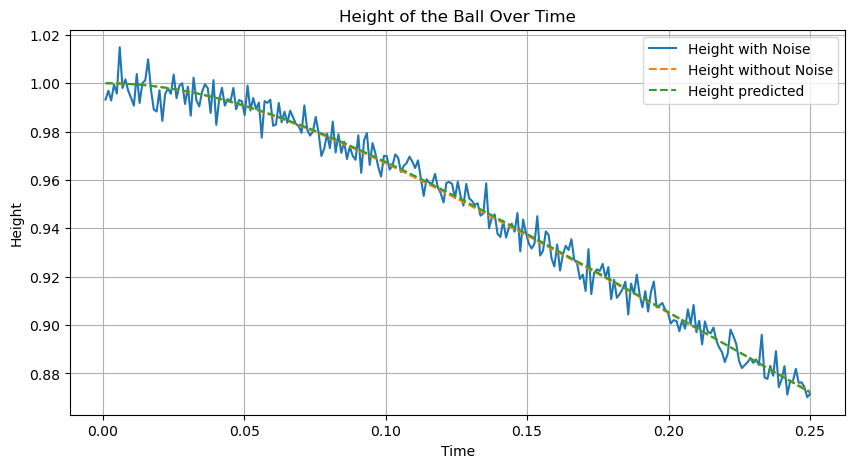

In [12]:
p_hat = np.array([0.16712946,1.80654545])

y_hat,s_ol = Model_sensitiv(p_hat,time)
print(s_ol.shape)

# # Use the sensitivity functions to evaluate the gradient
s_k_h = s_ol[:, 2]  # Sensitivity of height with respect to k
s_n_h = s_ol[:, 4]  # Sensitivity of height with respect to n

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(time, data_noise, label='Height with Noise')
plt.plot(time, data_non_noise, label='Height without Noise', linestyle='--')
plt.plot(time, y_hat, label='Height predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height of the Ball Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
def critgrad_sensitive( p, y, t, const):
    # Initial conditions for state and sensitivities
    xe0 = [constante.H, .0, 0., .0, 0.,0.]

    # Solve the extended ODE system
    sol = odeint(dynball_new, xe0, t, args=(p, const))
    y_hat = sol[:, 0]  # Extract the height predictions

    # Calculate the cost function as the sum of squared differences
    c = np.sum((y - y_hat)**2)

    # Use the sensitivity functions to evaluate the gradient
    s_k_h = sol[:, 2]  # Sensitivity of height with respect to k
    s_n_h = sol[:, 4]  # Sensitivity of height with respect to n
    grad = np.array([
        -2*np.sum(( y_hat-y) * s_k_h),  # Gradient with respect to k
        -2*np.sum(( y_hat-y) * s_n_h)   # Gradient with respect to n
    ])

    return c, grad

Iteration 1: Cost = 0.7541759392556883, Parameters = [0.97189476 1.07231768]
Iteration 2: Cost = 0.6943494820748599, Parameters = [0.94474598 1.13524896]
Iteration 3: Cost = 0.6417904782464786, Parameters = [0.91843728 1.19088087]
Iteration 4: Cost = 0.5952879807442619, Parameters = [0.8928688  1.24064308]
Iteration 5: Cost = 0.5538206404792789, Parameters = [0.8679559  1.28556266]
Iteration 6: Cost = 0.5165566608143408, Parameters = [0.84362702 1.32640463]
Iteration 7: Cost = 0.48282467005431684, Parameters = [0.81982153 1.36375535]
Iteration 8: Cost = 0.4520822291165758, Parameters = [0.79648792 1.39807472]
Iteration 9: Cost = 0.4238886311258192, Parameters = [0.77358229 1.42973052]
Iteration 10: Cost = 0.3978832720750063, Parameters = [0.75106719 1.4590216 ]
Iteration 11: Cost = 0.3737687622731136, Parameters = [0.72891068 1.48619423]
Iteration 12: Cost = 0.351297990268848, Parameters = [0.70708559 1.51145376]
Iteration 13: Cost = 0.33026413874558985, Parameters = [0.68556894 1.5349

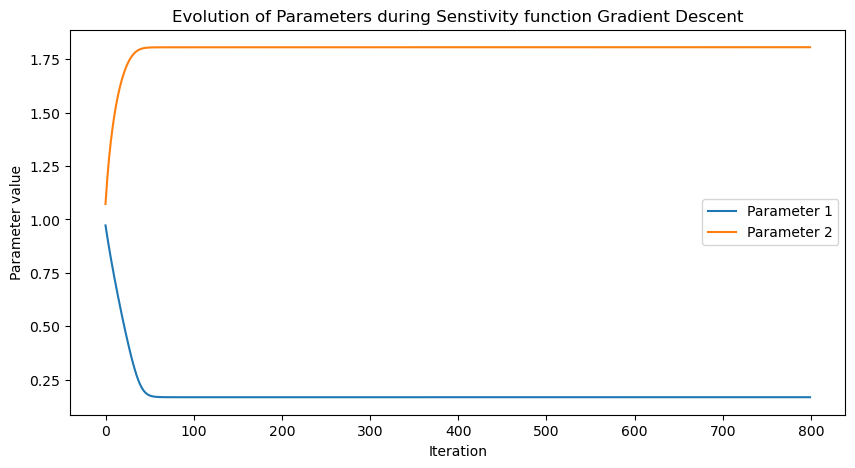

In [14]:
def gradient_descent_sentive(p_init, y, t, const, alpha, num_iterations):
    p = p_init.copy()
    p_history = []  # List to store the history of p values
    for i in range(num_iterations):
        c, grad = critgrad_sensitive(p, y, t,const=constante)
        p -= alpha * grad  # Update the parameter vector
        p_history.append(p.copy())  # Store the current value of p
        print(f"Iteration {i+1}: Cost = {c}, Parameters = {p}")
    return np.array(p_history)  # Return the history of p values as an array


# Run gradient descent and get the history of p values
p_init = np.array([1.0, 1.0])  # Initial parameter guess
alpha = 0.01  # Learning rate
num_iterations = 800  # Number of iterations
height = data_noise

# Perform the gradient descent to estimate the parameters
p_history = gradient_descent_sentive(p_init, height, time, constante, alpha, num_iterations)

# Plotting the evolution of the parameters
plt.figure(figsize=(10, 5))
for i in range(p_history.shape[1]):
    plt.plot(p_history[:, i], label=f'Parameter {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Evolution of Parameters during Senstivity function Gradient Descent')
plt.legend()
plt.show()

### Using Gauss-NewTon's Approach


In [15]:
def crit_Gauss_NewTon_sensitive(p, y, t):
    x0 = [constante.H, 0.0, .0, .0,.0,0]
    sol = odeint(dynball_new, x0, t, args=(p, constante))
    y_hat = sol[:, 0]  # Extract the height predictions from the solution

        # Calculate the cost function as the sum of squared differences
    c = 0.5*np.sum((y - y_hat)**2)
    
    f = np.array(y-y_hat) # 250 *1

    J = np.vstack((sol[:, 2], sol[:, 4])).T# Sensitivity of height with respect to k, n 2*250

    ga = J.T.dot(f)
    Ha = J.T.dot(J)   
    return c, ga,Ha


Iteration 1: Cost = 0.37708796962784413, Parameters = [10.1230076   4.75215509]
Iteration 2: Cost = 0.05993313276005457, Parameters = [43.28598301  8.17600609]
Iteration 3: Cost = 0.017996668553610026, Parameters = [28.88192864  7.98078348]
Parameter update resulted in negative value, reducing step size to 0.5
Iteration 4: Cost = 0.014486283494460368, Parameters = [13.84640232  7.39561408]
Iteration 5: Cost = 0.010690593567258102, Parameters = [2.77656917 6.37119517]
Parameter update resulted in negative value, reducing step size to 0.25
Cost increased, reducing step size to 0.125
Iteration 6: Cost = 0.0038380540994840716, Parameters = [2.77656917 6.37119517]
Iteration 7: Cost = 0.0038380540994840716, Parameters = [1.88781941 5.83088002]
Iteration 8: Cost = 0.0036955621317483677, Parameters = [1.36607849 5.35587684]
Iteration 9: Cost = 0.0036288387698705507, Parameters = [1.04131593 4.9418473 ]
Iteration 10: Cost = 0.003598936484541494, Parameters = [0.82826344 4.5821886 ]
Iteration 11

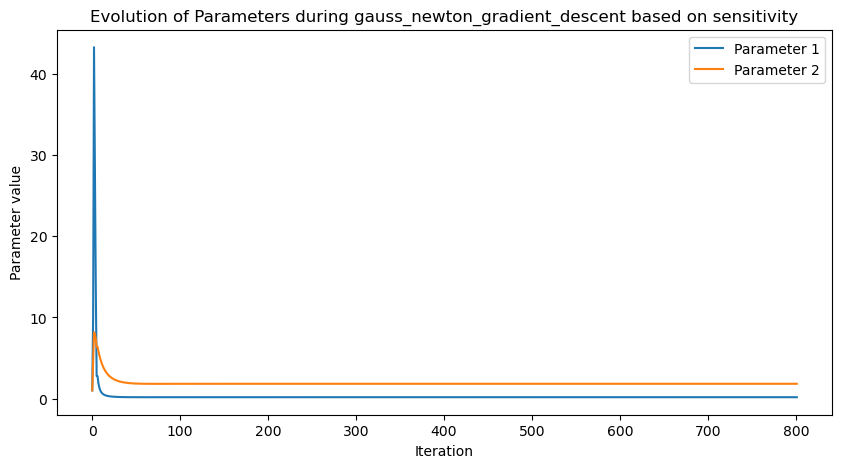

In [16]:
def gauss_newton_gradient_descent(p_init, y, t, const, initial_alpha, num_iterations):
    p = p_init.copy()
    p_history = []  # List to store the history of p values
    p_history.append(p)
    alpha = initial_alpha  # Start with the initial alpha value
    last_cost = float('inf')  # Initialize last cost as infinity
    finished = False
    eps_j = 1e-8
    eps_g = 1e-8
    k_max = 800
    k = 0
    while not finished:
        c, grad, Ha = crit_Gauss_NewTon_sensitive(p, y, t)

        # Calculate the descent direction
        d0 = np.linalg.solve(Ha, -grad)

        # Update parameters tentatively
        p_new = p + alpha * d0

        # Check if any updated parameters are negative, reduce alpha if so
        while np.any(p_new <= 0):
            alpha *= 0.5  # Reduce step size
            p_new = p + alpha * d0  # Recalculate the tentative new parameters
            print(f"Parameter update resulted in negative value, reducing step size to {alpha}")

        # Calculate new cost for p_new and compare with last_cost
        new_cost, _, _ = crit_Gauss_NewTon_sensitive(p_new, y, t)
        if new_cost > last_cost:
            alpha *= 0.5  # Halve the step size if the cost increases
            print(f"Cost increased, reducing step size to {alpha}")
        else:
            # Accept the new parameters since they are all positive and cost has not increased
            p = p_new
            last_cost = new_cost  # Update the last cost

        if new_cost < eps_j:
            print("Too small decrease of cost")
            finished = True    
        if np.sum(grad**2) < eps_g:
            print("Too small gradient")
            finished = True    
        if k >= k_max:
            print("Maximum iteration count reached")
            finished = True 

        # Store the current value of p and print the iteration details
        p_history.append(p.copy())
        print(f"Iteration {k+1}: Cost = {c}, Parameters = {p}")
        k += 1

    return np.array(p_history)  # Return the history of p values as an array

# Rest of your code for running the function and plotting





# Run gradient descent and get the history of p values
p_init = np.array([1.0, 1.0])  # Initial parameter guess
alpha = 1 # Learning rate
num_iterations = 1000  # Number of iterations
height = data_noise

# Perform the gradient descent to estimate the parameters
p_history = gauss_newton_gradient_descent(p_init, height, time, constante, alpha, num_iterations)

# Plotting the evolution of the parameters
plt.figure(figsize=(10, 5))
for i in range(p_history.shape[1]):
    plt.plot(p_history[:, i], label=f'Parameter {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Evolution of Parameters during gauss_newton_gradient_descent based on sensitivity')
plt.legend()
plt.show()

In [17]:
def crit_Gauss_NewTon(p, y, t):
    x0 = [constante.H, .0]  # Initial condition: starting at the first height value with zero velocity
    sol = odeint(dynball, x0, t, args=(p, constante))
    y_hat = sol[:, 0]  # Extract the height predictions from the solution

        # Calculate the cost function as the sum of squared differences
    c = 0.5*np.sum((y - y_hat)**2)
    
    # Calculate the gradient of the cost function using finite difference
    delta = 1e-5  # A small perturbation for finite difference

    f = np.array(y-y_hat).transpose()
    J = np.zeros((len(y_hat),len(p))) 

    for i in range(len(p)):
        p_delta = np.copy(p)
        p_delta[i] += delta
        sol_delta = odeint(dynball, x0, t, args=(p_delta, constante))
        y_hat_delta = sol_delta[:, 0]
        J[:,i] = -(y_hat_delta-y_hat)/delta
    
    
    ga = J.transpose().dot(f)
    Ha = J.transpose().dot(J)    
    return c, ga,Ha


descent direction [-66.87120228 -24.1883525 ]
Too small decrease of cost
p:  [0.16510807 1.784067  ]
j(p):  0.003027894623449572
g(p):  [ 0.0021039  -0.00022863]
Iterations:  658
(659, 2)


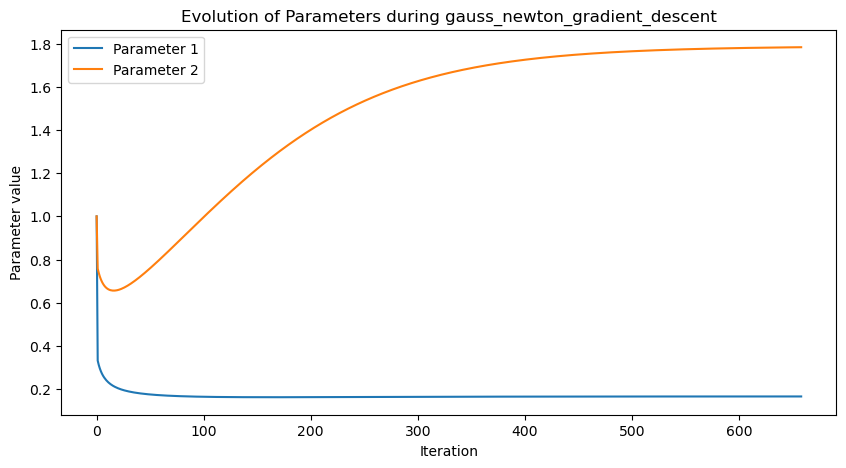

In [18]:
y_ref = data_noise

# Inital gest of the parameter 
p0 = [1.0,1.0]

# Inital evaluation 
c0, g0, H0 =crit_Gauss_NewTon(p=p0,y=y_ref,t=time)

# Descent direction

d0 = np.linalg.solve(H0,-g0).transpose()
print('descent direction', d0)

finished = False
eps_j = 1e-8
eps_g = 1e-8
k_max = 800
k = 0
p_history =[]
p_history.append(p0)
while not finished:
    # line search
    alpha = 0.01 
    p1 = p0+alpha*d0
    c_t, g_t, H_t =crit_Gauss_NewTon(p=p0+alpha*d0,y=y_ref,t=time)
    # Descent direction
    d1 = np.linalg.solve(H_t,-g_t).transpose()
    p_history.append(p1)

    if c0-c_t < eps_j:
        print("Too small decrease of cost")
        finished = True    
    if np.sum(g_t**2) < eps_g:
        print("Too small gradient")
        finished = True    
    if k >= k_max:
        print("Maximum iteration count reached")
        finished = True    
        
    
    c0 = c_t
    g0 = g_t
    p0 = p1
    d0 = d1
    H0 = H_t
    
    k = k+1

print('p: ',p0)
print('j(p): ',c0)
print('g(p): ',g0)
print('Iterations: ',k)
p_history =np.array(p_history)

print(p_history.shape)

# Plotting the evolution of the parameters
plt.figure(figsize=(10, 5))
for i in range(p_history.shape[1]):
    plt.plot(p_history[:, i], label=f'Parameter {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Evolution of Parameters during gauss_newton_gradient_descent')
plt.legend()
plt.show()

(249,)
(249, 4)
[5.5421653215657966e-05, 5.706936685952686e-05, 4.482758722760273e-05, 3.8207325412605535e-05]


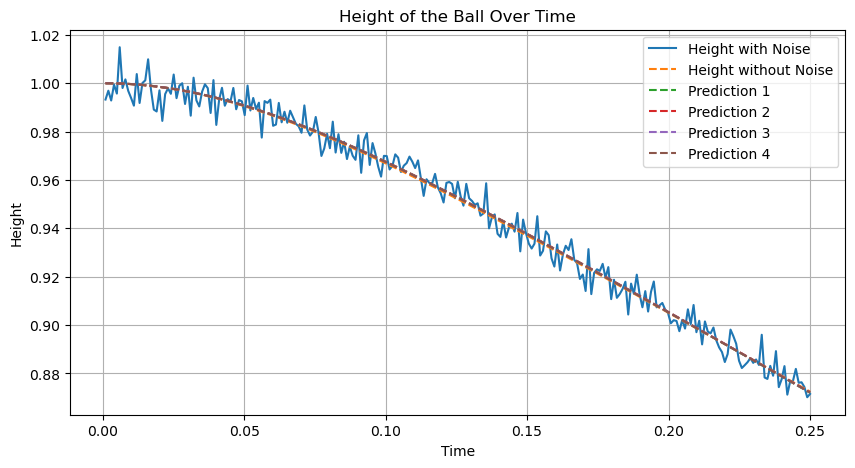

In [19]:
p_hat = np.array([[0.16364295,1.77462433 ],
                  [0.16510807 ,1.78406],
                  [0.16712946,1.80654545],
                  [0.16871785,1.82283597],
                  ])

print(data_non_noise.shape)
y_hat_stock = np.zeros([data_noise.shape[0],p_hat.shape[0]])
print(y_hat_stock.shape)
residul = []
for i in range(len(p_hat)):
    y_hat,s_ol = Model_sensitiv(p_hat[i],time)
    resi = np.sum((y_hat-data_non_noise)**2)
    residul.append(resi)
    y_hat_stock[:,i]=y_hat


print(residul)



# # Use the sensitivity functions to evaluate the gradient
s_k_h = s_ol[:, 2]  # Sensitivity of height with respect to k
s_n_h = s_ol[:, 4]  # Sensitivity of height with respect to n

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(time, data_noise, label='Height with Noise')
plt.plot(time, data_non_noise, label='Height without Noise', linestyle='--')
for i in range(y_hat_stock.shape[1]):
    plt.plot(time, y_hat_stock[:, i], label=f'Prediction {i+1}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height of the Ball Over Time')
plt.legend()
plt.grid(True)
plt.show()